# Use the telegraph model to generate some time series data for us so we can use it to train neural networks


My objective is to adapt this to produce some time series data for the different transcription factors (TFs) under different stresses. 

Let's start with the SSA model built for a previous practice

In [2]:
import matplotlib.pyplot as plt
import multiprocessing
import tqdm
import numpy as np
import os
import scipy.stats as st
import numba
import biocircuits
import itertools

# Define the update matrix for the reactions
# Columns: G, G*, M
# Columns: G, G*, M
update_matrix = np.array([
    [-1, 1, 0],   # G -> G* (Gene activation)
    [1, -1, 0],   # G* -> G (Gene deactivation)
    [0, 0, 1],    # G -> G + M (mRNA production)
    [0, 0, -1],   # M -> 0 (mRNA degradation)
], dtype=int)

def telegraph_model_propensity(propensities, population, t, sigma_u, sigma_b, rho, d):
    """
    Updates the propensities for the telegraph model reactions based on defined rates.

    Parameters:
        propensities: Array of propensities
        population: Array of species populations [G, G*, M]
        t: Time (not used but required by signature)
        sigma_u: Rate of G -> G* (activation)
        sigma_b: Rate of G* -> G (deactivation)
        rho: Rate of G -> G + M (mRNA production)
        d: Rate of M -> 0 (mRNA degradation)
    """
    # Unpack population
    G, G_star, M = population
    
    # Update propensities for each reaction
    propensities[0] = sigma_u * G          # G -> G*
    propensities[1] = sigma_b * G_star     # G* -> G
    propensities[2] = rho * G              # G -> G + M
    propensities[3] = d * M                # M -> 0

def sample_discrete_scipy(probs):
    """Randomly sample an index with probability given by probs."""
    return st.rv_discrete(values=(range(len(probs)), probs)).rvs()

def sample_discrete(probs):
    """Randomly sample an index with probability given by probs."""
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

def gillespie_draw(propensity_func, propensities, population, t, args=()):
    """
    Draws a reaction and the time it took to do that reaction.
    
    Parameters
    ----------
    propensity_func : function
        Function with call signature propensity_func(population, t, *args)
        used for computing propensities. This function must return
        an array of propensities.
    population : ndarray
        Current population of particles
    t : float
        Value of the current time.
    args : tuple, default ()
        Arguments to be passed to `propensity_func`.
        
    Returns
    -------
    rxn : int
        Index of reaction that occured.
    time : float
        Time it took for the reaction to occur.
    """
    # Compute propensities
    propensity_func(propensities, population, t, *args)
    
    # Sum of propensities
    props_sum = propensities.sum()
    
    # Compute next time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = propensities / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    
    return rxn, time

def gillespie_ssa(propensity_func, update, population_0, time_points, args=()):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from probability distribution of particle counts over time.
    
    Parameters
    ----------
    propensity_func : function
        Function of the form f(params, t, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func.        

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    propensities = np.zeros(update.shape[0])
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(propensity_func, propensities, population, t, args)
                
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out

100%|██████████| 1000/1000 [00:46<00:00, 21.31it/s]


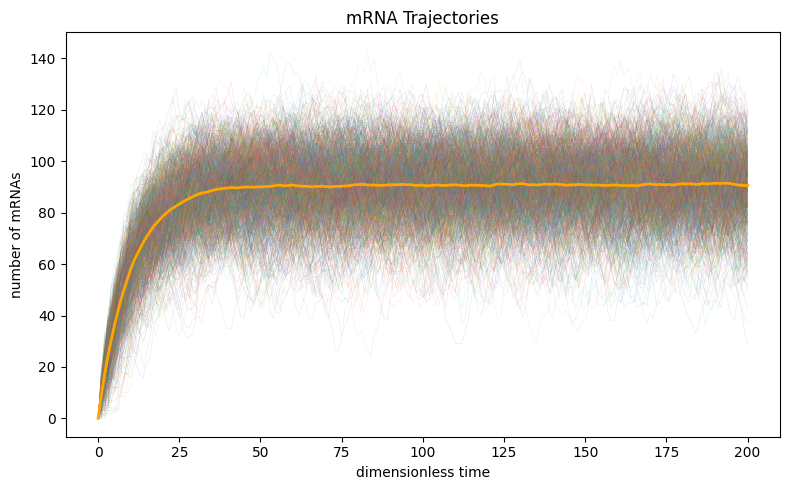

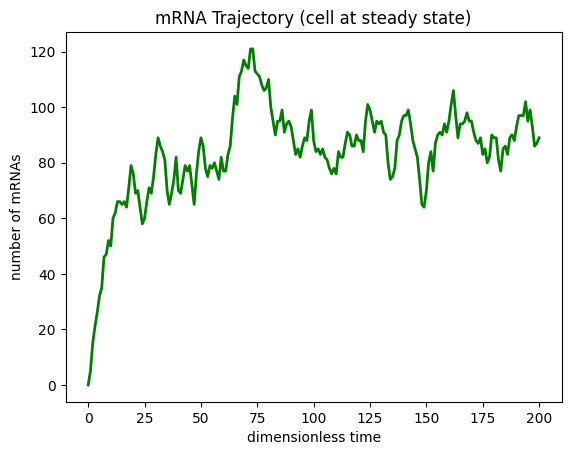

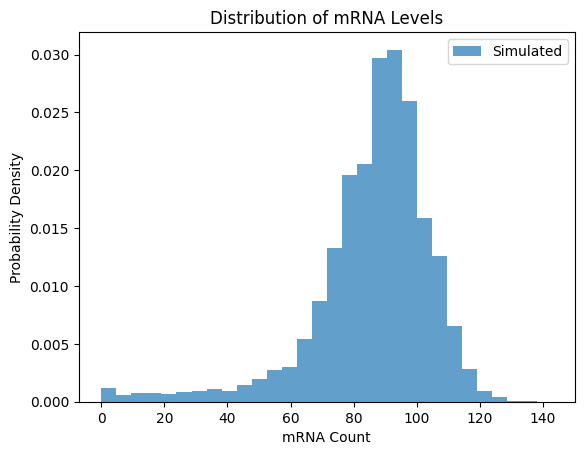

mRNA mean copy number = 86.12883582089552
mRNA variance = 355.9722570526472
Fano factor for mRNA: 4.13
Expected Fano factor for mRNA (Exact): 1.76


/tmp/ipykernel_61890/162877213.py:72: RuntimeWarning: invalid value encountered in divide
  fano_m_time = samples[:, :, 2].var(axis=0) / samples[:, :, 2].mean(axis=0)


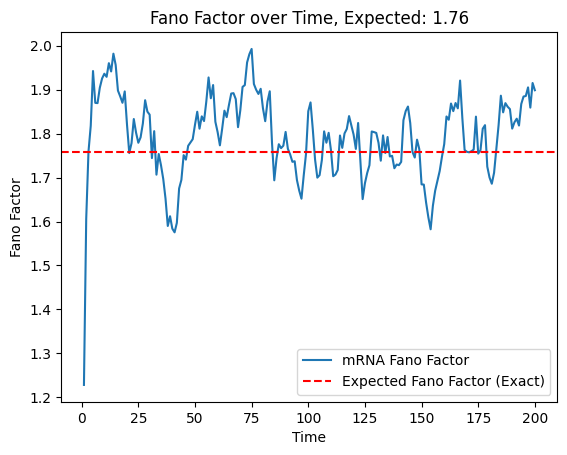

In [4]:
# Define the rates for each reaction (constants)
# To match theoretical and actual Fano factors, ensure:
# 1. Set sigma_b >> sigma_u
# 2. Set rho >> sigma_b
# 3. Reaction sampled at Steady State, and t_ss >> 10 / d

sigma_u = 0.1       # Rate of G -> G* (activation)
sigma_b = 1.0       # Rate of G* -> G (deactivation)
rho = 10.0          # Rate of G -> G + M (mRNA production)
d = 0.1             # Rate of M -> 0 (mRNA degradation)

# Set simulation parameters
params = (sigma_u, sigma_b, rho, d)
time_points = np.linspace(0, 200, 201)  # Time range
# To ensure steady state, set time_points[-1] >> 10 / d
if time_points[-1] < 10 / d:
    time_points = np.linspace(0, 10 / d, int(10 / d * 10) + 1)

population_0 = np.array([1, 0, 0], dtype=int)  # Initial [G, G*, M]
size = 1000  # Number of stochastic simulations

# Seed random number generator for reproducibility
np.random.seed(42)

# Run Gillespie simulations
samples = np.empty((size, len(time_points), 3), dtype=int)
for i in tqdm.tqdm(range(size)):
    samples[i, :, :] = gillespie_ssa(telegraph_model_propensity, update_matrix, population_0, time_points, args=params)

# Plot trajectories and mean using matplotlib
fig, axs = plt.subplots(1, 1, figsize=(8, 5))

# Plot mRNA trajectories
for x in samples[:, :, 2]:
    axs.plot(time_points, x, linewidth=0.3, alpha=0.2)
axs.plot(time_points, samples[:, :, 2].mean(axis=0), linewidth=2, color='orange')
axs.set_xlabel('dimensionless time')
axs.set_ylabel('number of mRNAs')
axs.set_title('mRNA Trajectories')

plt.tight_layout()
plt.show()

# Plot one mRNA trajectory
plt.plot(time_points, samples[-50, :, 2], linewidth=2, color='green')
plt.xlabel('dimensionless time')
plt.ylabel('number of mRNAs')
plt.title('mRNA Trajectory (cell at steady state)')
plt.show()

# Plot the mRNA level distribution
plt.hist(samples[:, :, 2].flatten(), bins=30, density=True, alpha=0.7, label='Simulated')
plt.title("Distribution of mRNA Levels")
plt.xlabel("mRNA Count")
plt.ylabel("Probability Density")
plt.legend()
plt.show()

# Output mean values and noise
print("mRNA mean copy number =", samples[:, :, 2].mean())
print("mRNA variance =", samples[:, :, 2].std() ** 2)

# Calculate Fano factor
fano_m = samples[:, :, 2].var() / samples[:, :, 2].mean()
print(f'Fano factor for mRNA: {fano_m:.2f}')

# Calculate exact theoretical Fano factor for telegraph model
expected_fano_m_exact = 1 + (rho * sigma_u) / ((sigma_b + sigma_u) * (sigma_b + d + sigma_u))
print(f'Expected Fano factor for mRNA (Exact): {expected_fano_m_exact:.2f}')

# Plot the Fano factor over time
fano_m_time = samples[:, :, 2].var(axis=0) / samples[:, :, 2].mean(axis=0)
plt.plot(time_points, fano_m_time, label='mRNA Fano Factor')
plt.axhline(expected_fano_m_exact, color='red', linestyle='--', label='Expected Fano Factor (Exact)')
plt.xlabel('Time')
plt.ylabel('Fano Factor')
plt.legend()
plt.title(f'Fano Factor over Time, Expected: {expected_fano_m_exact:.2f}')
plt.show()
